Prueba Def
=====

Epoch 1/50, Training Loss: 0.40571190300195115, Validation Loss: 0.19998571875232898
Epoch 2/50, Training Loss: 0.18331644282392834, Validation Loss: 0.09266892400511416
Epoch 3/50, Training Loss: 0.150305853654509, Validation Loss: 0.07579397257808616
Epoch 4/50, Training Loss: 0.12983821073304053, Validation Loss: 0.0783861859352088
Epoch 5/50, Training Loss: 0.12370545792838801, Validation Loss: 0.06843286607982609
Epoch 6/50, Training Loss: 0.11298989912737971, Validation Loss: 0.06542936062720278
Epoch 7/50, Training Loss: 0.1080248210741126, Validation Loss: 0.07768566198116252
Epoch 8/50, Training Loss: 0.1059239866292995, Validation Loss: 0.06613611597146188
Epoch 9/50, Training Loss: 0.0999711024372474, Validation Loss: 0.06342421881995994
Epoch 10/50, Training Loss: 0.100301085088564, Validation Loss: 0.06239530907086195
Epoch 11/50, Training Loss: 0.09592171207718227, Validation Loss: 0.05938366358269927
Epoch 12/50, Training Loss: 0.095727116452611, Validation Loss: 0.06185

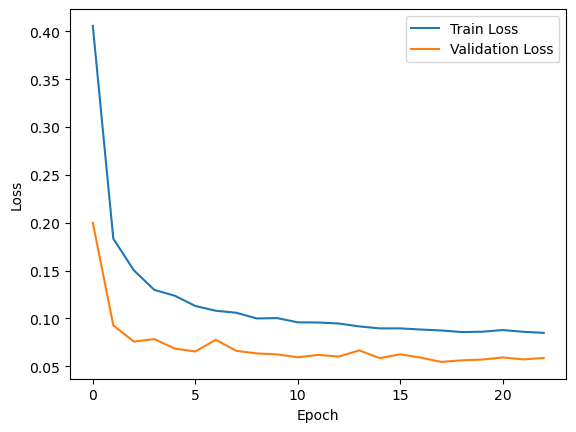

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Cargar los DataLoaders
train_loader = torch.load('train (2).pth', map_location=torch.device('cpu'))
val_loader = torch.load('val (2).pth', map_location=torch.device('cpu'))
test_loader = torch.load('test (2).pth', map_location=torch.device('cpu'))

# Parámetros de la red
input_size = 6001
hidden_size = [256, 128, 64]
output_size = 20
learning_rate = 0.001
num_epochs = 50

# Definir el modelo MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(hidden_size[2], output_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
    
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)  # Última capa sin activación
        return x

# Inicializar modelo, criterio y optimizador
model = SimpleMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Configuración de Early Stopping
best_loss = float('inf')
patience, trials = 5, 0

# Listas para almacenar las pérdidas
train_losses, val_losses = [], []

# Ciclo de entrenamiento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))
    
    if val_loss < best_loss:
        best_loss = val_loss
        trials = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping on epoch {epoch}")
            break
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

# Gráficas de pérdidas
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [32]:
# Evaluar el modelo en el conjunto de validación
predictions = []
true_values = []

with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        true_values.append(targets.cpu().numpy())

# Convertir listas a arrays
predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

# Calcular las métricas
mae = mean_absolute_error(true_values, predictions)
rmse = mean_squared_error(true_values, predictions, squared=False)
r2 = r2_score(true_values, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error: 0.12768404185771942
Root Mean Squared Error: 0.17468102276325226
R² Score: -1.282723307609558


C:\Users\GAMER\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
for i in range(10): 
    print(f'Actual: {true_values[i]}, Predicted: {predictions[i]}')

Actual: [-0.5665672  -0.56653285 -0.566675   -0.56693584 -0.5669635  -0.56705856
 -0.56662303 -0.5489803  -0.5550589  -0.51605844 -0.49169514 -0.52561855
  1.1248245   1.0342087   0.69092774  0.42846918  2.6960928   3.3647609
  3.6237009   3.7547095 ], Predicted: [-0.56657016 -0.56654656 -0.5667301  -0.5669772  -0.5670156  -0.5671177
 -0.5666198  -0.53148824 -0.43505302 -0.2570517  -0.04343456  0.22891629
  0.51398134  0.78151417  1.0447401   1.4545455   1.9169207   2.6254826
  3.1121042   3.2828104 ]
Actual: [-0.566706   -0.5665549  -0.56669116 -0.56678474 -0.56690663 -0.5669293
 -0.5664023  -0.5556863  -0.46688113 -0.32665914 -0.07262098 -0.07577629
  0.12619272 -0.2756035  -0.4978024  -0.3951365   0.27748436  0.34806323
  0.38618526  0.41228494], Predicted: [-0.5665361  -0.5664402  -0.5664608  -0.5663713  -0.5665405  -0.56668216
 -0.5665692  -0.5582874  -0.5344134  -0.4951893  -0.44811487 -0.37510756
 -0.2907209  -0.18965666 -0.09981216  0.01599301  0.19001722  0.48091438
  0.572298

In [34]:
from torchsummary import summary

# Mueve el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Imprime el resumen del modelo
summary(model, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]       1,536,512
         LeakyReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
         LeakyReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
         LeakyReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 20]           1,300
Total params: 1,578,964
Trainable params: 1,578,964
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.01
Params size (MB): 6.02
Estimat